<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
# #finding EL2O by minimization
# tf.reset_default_graph()

# batch_size  = 64
# hidden_size = 8

# def inference(in_net):
#     with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
#         net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
#     return net

# def generator(in_net):
#     with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
#         net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 784, name='dense_5', activation=None)
#     return net

# lr    = tf.placeholder_with_default(0.001,shape=[])

# x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

# prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

# mu, sigma        = tf.split(inference(x), 2, axis=-1)
# sigma            = tf.nn.softplus(sigma) + 0.0001
# approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

# z                = approx_posterior.sample()

# sample_size      = tf.placeholder_with_default(100,shape=[])

# z_samples        = approx_posterior.sample(sample_size)

# x_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

# x_sims           = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

# data_likelihood  = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

# kl_divergence    = tfd.kl_divergence(approx_posterior, prior)

# elbo             = -tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

# with tf.variable_scope("posteriorELBO"):
#     mu_elbo    = tf.Variable(initial_value=np.zeros((batch_size,hidden_size)), dtype=tf.float32)
#     sigma_elbo = tf.Variable(initial_value=np.ones((batch_size,hidden_size *(hidden_size +1) // 2)), dtype=tf.float32)
# sigma_t_elbo = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_elbo), transform=tf.nn.softplus)

# approx_posterior_elbo = tfd.MultivariateNormalTriL(loc=mu_elbo,scale_tril=sigma_t_elbo, name='posteriorELBO')


# with tf.variable_scope("posteriorEL2O"):
#     mu_el2 = tf.Variable(initial_value=np.zeros((batch_size,hidden_size)), dtype=tf.float32)
#     sigma_el2 = tf.Variable(initial_value=np.ones((batch_size,hidden_size *(hidden_size +1) // 2)), dtype=tf.float32)
# sigma_t_el2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_el2), transform=tf.nn.softplus)

# approx_posterior_el2o = tfd.MultivariateNormalTriL(loc=mu_el2,scale_tril=sigma_t_el2, name='posteriorEL2O')

# z_sample_elbo     = approx_posterior_elbo.sample()

# z_sample_el2o     = approx_posterior_el2o.sample()

# zmean_elbo        = approx_posterior_elbo.mean()

# zmean_el2o        = approx_posterior_el2o.mean()

# likeli_zmean_elbo = tfd.Independent(tfd.Bernoulli(logits=generator(zmean_elbo)))

# likeli_zmean_el2o = tfd.Independent(tfd.Bernoulli(logits=generator(zmean_el2o)))

# kl_divergence_elbo= tfd.kl_divergence(approx_posterior_elbo, prior) 

# mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])

# zz                = tf.identity(z_sample_el2o)

# elbo_logits       = tf.boolean_mask(generator(z_sample_elbo), mymask, axis=1)

# el2o_logits       = tf.boolean_mask(generator(zz), mymask, axis=1)

# data_likelihood_elbo = tfd.Independent(tfd.Bernoulli(logits=elbo_logits))

# data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))

# masked_data       = tf.boolean_mask(x, mymask, axis=1)
    
# mask_elbo         = -tf.reduce_mean(data_likelihood_elbo.log_prob(masked_data)- kl_divergence_elbo,axis=0)

# mask_post         = - tf.reduce_mean(prior.log_prob(zz)) - tf.reduce_mean(data_likelihood_el2o.log_prob(masked_data))

# mask_post_approx  = - approx_posterior_el2o.log_prob(zz)

# dptdz             = tf.gradients(mask_post,zz) 
# dptdz             = tf.gather(dptdz, 0)

# dpdz              = tf.gradients(mask_post_approx,zz) 
# dpdz              = tf.gather(dpdz, 0)

# hesst             = tf.hessians(mask_post, zz)
# hesst             = tf.gather(hesst, 0)
# hesst2            = tf.reduce_sum( hesst, axis = -1 )
# lowt              = tf.matrix_band_part(hesst2, -1, 0)

# hess              = tf.hessians(mask_post_approx, zz)
# hess              = tf.gather(hess, 0)
# hess2             = tf.reduce_sum(hess, axis = -1 )
# lowt2             = tf.matrix_band_part(hess2, -1, 0)

# mask_el2o         = tf.reduce_mean(tf.math.square(dpdz-dptdz))+tf.reduce_mean(tf.math.square((lowt-lowt2)))

# z_samples_elbo    = approx_posterior_elbo.sample(sample_size)

# x_samples_elbo    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_elbo))).sample(sample_size)

# z_samples_el2o    = approx_posterior_el2o.sample(sample_size)

# x_samples_el2o    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_el2o))).sample(sample_size)

In [0]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size  = 256
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z                = approx_posterior.sample()

sample_size      = tf.placeholder_with_default(1,shape=[])

z_samples        = approx_posterior.sample(sample_size)

x_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

x_sims           = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood  = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence    = tfd.kl_divergence(approx_posterior, prior)

elbo             = -tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

ini_val  = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("approxposterior2",reuse=True):
  mu_new      = tf.Variable(np.ones((1,hidden_size))*10., dtype=np.float32)
  sigma_new   = tf.Variable(np.ones((1,hidden_size))*4., dtype=np.float32)
  
#idellay I wanna have a loop where mu_new and sigma_new get updated
approx_posterior2 = tfd.MultivariateNormalDiag(loc=mu_new,scale_diag=sigma_new, name='approxposterior2')

update1           = tf.assign(mu_new,tf.expand_dims(tf.gather(mu,0),0))

update2           = tf.assign(sigma_new,tf.expand_dims(tf.gather(sigma,0),0))

zz                = approx_posterior2.sample()
shape1            = tf.shape(zz)
#mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
xx                = tf.identity(zz)
el2o_logits       = generator(xx)#tf.boolean_mask(generator(xx), mymask, axis=1)
shape2            = tf.shape(el2o_logits)
data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))
x_corr            = tf.placeholder(shape=[784], dtype=tf.float32)
m_data            = x_corr#tf.boolean_mask(x, mymask, axis=1)


p_of_z            = -approx_posterior.log_prob(xx)#-prior.log_prob(xx)-data_likelihood_el2o.log_prob(m_data)##
shape3            = tf.shape(p_of_z)
p_of_z            = tf.gather(p_of_z,0)
shape4            = tf.shape(p_of_z)
dpdz              = tf.gradients(p_of_z, xx) 

dpdz              = tf.gather(dpdz, 0)

dpdzz             = tf.gradients(dpdz,xx)
dpdzz             = tf.gather(dpdzz, 0)

sigma2            = tf.math.reciprocal(dpdzz)

sigma_n           = tf.math.sqrt(sigma2)

mu_n              = -tf.einsum('ij,ij->ij', sigma2,dpdz)+xx

update3           = tf.assign(mu_new,mu_n)

update4           = tf.assign(sigma_new,sigma_n)

z_samples_el2o    = approx_posterior2.sample(sample_size)

x_samples_el2o    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_el2o))).sample(sample_size)

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)
#datagen.fit(x_train.reshape((50000,28,28,1))) only needed if data trafos depend on the data itself

In [0]:


#opt_op2a= optimizer.minimize(mask_elbo,var_list=[mu_elbo,sigma_elbo])

#opt_op2b= optimizer.minimize(mask_el2o,var_list=[mu_el2,sigma_el2])

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
losses_data = []

In [41]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [42]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-3
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 255.91397 228.79645 0.0
0 218.29906 212.54105 0.0
0 210.24918 206.30057 0.0
0 206.56581 189.89166 0.0
0 197.68604 189.30173 0.0
0 195.59995 187.12065 0.0
0 198.15099 185.20593 0.0
0 191.39597 187.25084 0.0
0 189.19252 182.06256 0.0
0 181.57916 175.34695 0.0
0 181.88478 171.47734 0.0
0 181.16534 171.51323 0.0
0 175.69083 162.58125 0.0
0 165.8811 164.38643 0.0
0 171.26324 162.89754 0.0
0 169.20782 147.0044 0.0
0 158.959 150.38559 0.0
0 160.84586 148.56422 0.0
0 159.75026 138.84735 0.0
new epoch
1 158.90628 142.2967 0.0
1 153.44196 146.85605 0.0
1 154.53 144.76532 0.0
1 150.47992 136.9594 0.0
1 148.77483 135.73584 0.0
1 152.0544 133.08072 0.0
1 144.53746 138.11292 0.0
1 148.6976 142.25592 0.0
1 147.29202 140.83224 0.0
1 146.91324 135.40222 0.0
1 146.65393 134.6664 0.0
1 144.53392 138.19022 0.0
1 146.66888 131.94379 0.0
1 143.12988 133.51367 0.0
1 141.91815 137.9513 0.0
1 142.8355 125.312996 0.0
1 140.8357 129.76682 0.0
1 137.07272 128.16745 0.0
1 138.76816 123.52784 0.0
new ep

KeyboardInterrupt: ignored

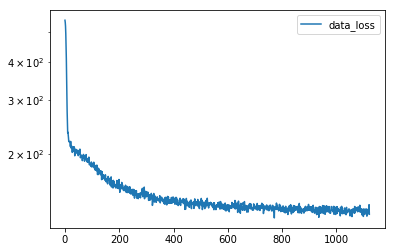

In [43]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res    = sess.run(z_samples, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

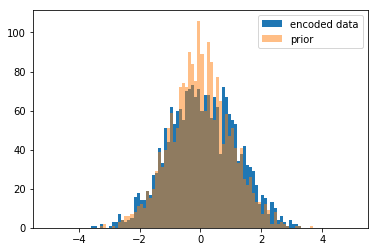

In [46]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

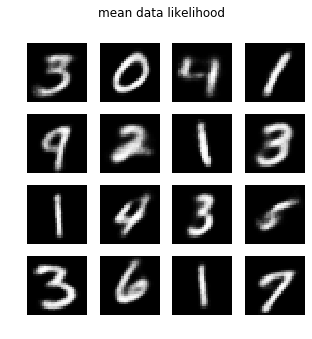

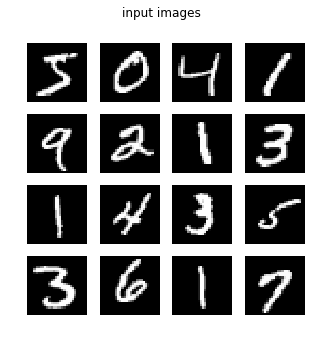

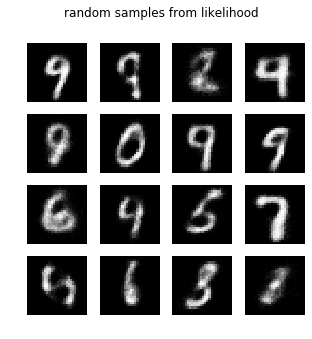

In [47]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_train[0:batch_size], sample_size: 100})
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('random samples from likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
# mask = np.ones(IMAGE_SHAPE, dtype=int)
# #mask[0:12,0:12]=0
# mask = mask.reshape((28*28))

# mask = np.asarray([mask]*batch_size)
# #print(mask.shape)
# masked_data = x_valid[0:batch_size]*mask

# mask = np.ones(IMAGE_SHAPE, dtype=int)
# #mask[0:12,0:12]=0
# mask = mask.reshape((28*28))

In [49]:
c, c1, m, m1=sess.run([sigma,sigma_new, mu, mu_new], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])

[0.0870524  0.23434843 0.10223543 0.20265698 0.2377598  0.28150916
 0.15962522 0.10591472]
[4. 4. 4. 4. 4. 4. 4. 4.]
[ 0.5675209   0.6061168  -0.51741606  0.30289656  1.7303598  -0.6446508
  1.9662706  -0.1225074 ]
[10. 10. 10. 10. 10. 10. 10. 10.]


In [50]:
sess.run([mu_n, sigma_n, shape1, shape2,shape3,shape4], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})

[array([[ 0.56752014,  0.60611725, -0.517416  ,  0.30289602,  1.73036   ,
         -0.6446514 ,  1.9662709 , -0.12250745]], dtype=float32),
 array([[0.0870524 , 0.23434843, 0.10223542, 0.20265698, 0.2377598 ,
         0.28150916, 0.15962522, 0.10591473]], dtype=float32),
 array([1, 8], dtype=int32),
 array([  1, 784], dtype=int32),
 array([256], dtype=int32),
 array([], dtype=int32)]

In [51]:
sess.run([dpdz,dpdzz], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})

[array([[867.4388 , 134.16055, 722.70337, 136.45108, 131.22528, 188.76947,
         323.47098, 829.98206]], dtype=float32),
 array([[131.95885 ,  18.208572,  95.67472 ,  24.34876 ,  17.68981 ,
          12.61871 ,  39.246143,  89.14301 ]], dtype=float32)]

In [52]:
_, _=sess.run([update1,update2], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})
c, c1, m, m1=sess.run([sigma,sigma_new, mu, mu_new], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])


[0.0870524  0.23434843 0.10223543 0.20265698 0.2377598  0.28150916
 0.15962522 0.10591472]
[0.0870524  0.23434843 0.10223543 0.20265698 0.2377598  0.28150916
 0.15962522 0.10591472]
[ 0.5675209   0.6061168  -0.51741606  0.30289656  1.7303598  -0.6446508
  1.9662706  -0.1225074 ]
[ 0.5675209   0.6061168  -0.51741606  0.30289656  1.7303598  -0.6446508
  1.9662706  -0.1225074 ]


In [53]:
sess.run([mu_n, sigma_n, shape1], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})

[array([[ 0.5675209 ,  0.6061168 , -0.51741606,  0.30289656,  1.7303598 ,
         -0.6446508 ,  1.9662706 , -0.12250741]], dtype=float32),
 array([[0.0870524 , 0.23434843, 0.10223542, 0.20265698, 0.2377598 ,
         0.28150916, 0.15962522, 0.10591473]], dtype=float32),
 array([1, 8], dtype=int32)]

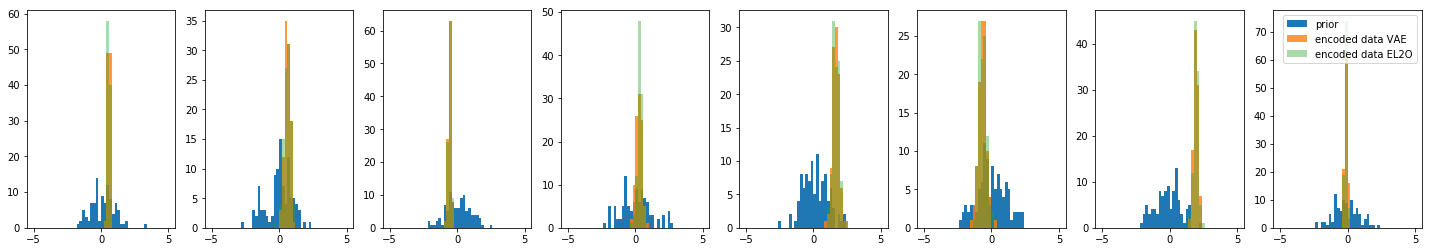

In [54]:
res3 = sess.run(z_samples_el2o,feed_dict={x_corr: x_train[0], x: x_train[0:batch_size], sample_size:100})
res2 = sess.run(z_samples,feed_dict={x_corr: x_train[0], x: x_train[0:batch_size], sample_size:100})
res2 = res2[:,0,:]
res3 = res3[:,0,:]
f=plt.figure()
f.set_figheight(4)
f.set_figwidth(25)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  hist(randn(len(res2[:,ii].flatten())),50,range=[-5,5],alpha=1.,label='prior');
  hist(res2[:,ii].flatten(),50,range=[-5,5],alpha=0.8, label='encoded data VAE');
  hist(res3[:,ii].flatten(),50,range=[-5,5],alpha=0.4,label='encoded data EL2O');
legend()

In [55]:
sess.run([dpdz,dpdzz,sigma2],feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})

[array([[ 0.5089517,  0.7143883, -9.882124 , -0.771129 ,  2.9911175,
          6.783386 , -5.1864686, -6.8891006]], dtype=float32),
 array([[131.95885 ,  18.208572,  95.67472 ,  24.34876 ,  17.68981 ,
          12.61871 ,  39.246143,  89.14301 ]], dtype=float32),
 array([[0.00757812, 0.05491919, 0.01045208, 0.04106985, 0.05652972,
         0.07924741, 0.02548021, 0.01121793]], dtype=float32)]

In [56]:
_, _=sess.run([update3,update4],feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})
c, c1, m, m1=sess.run([sigma,sigma_new, mu, mu_new],feed_dict={x_corr: x_train[0], x: x_train[0:batch_size]})

print(c[0])
print(c1[0])
print(m[0])
print(m1[0])

[0.0870524  0.23434843 0.10223543 0.20265698 0.2377598  0.28150916
 0.15962522 0.10591472]
[0.0870524  0.23434843 0.10223542 0.20265698 0.2377598  0.28150916
 0.15962522 0.10591473]
[ 0.5675209   0.6061168  -0.51741606  0.30289656  1.7303598  -0.6446508
  1.9662706  -0.1225074 ]
[ 0.5675209   0.6061168  -0.51741606  0.30289653  1.7303598  -0.6446508
  1.9662706  -0.1225074 ]


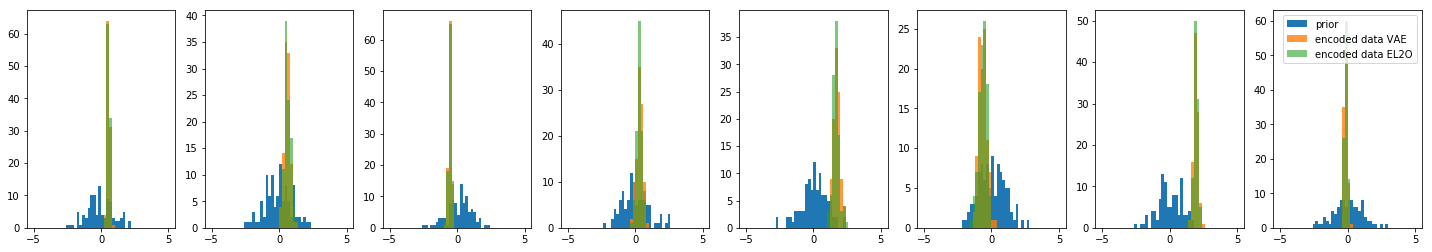

In [58]:
res3 = sess.run(z_samples_el2o,feed_dict={x_corr: x_train[0], x: x_train[0:batch_size], sample_size:100})
res2 = sess.run(z_samples,feed_dict={x_corr: x_train[0], x: x_train[0:batch_size], sample_size:100})
res2 = res2[:,0,:]
res3 = res3[:,0,:]
f=plt.figure()
f.set_figheight(4)
f.set_figwidth(25)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  hist(randn(len(res2[:,ii].flatten())),50,range=[-5,5],alpha=1.,label='prior');
  hist(res2[:,ii].flatten(),50,range=[-5,5],alpha=0.8, label='encoded data VAE');
  hist(res3[:,ii].flatten(),50,range=[-5,5],alpha=0.6,label='encoded data EL2O');
legend()

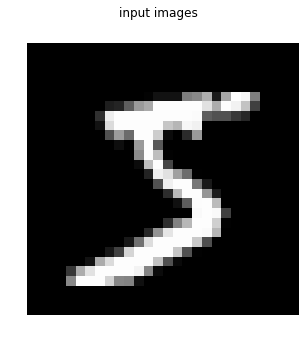

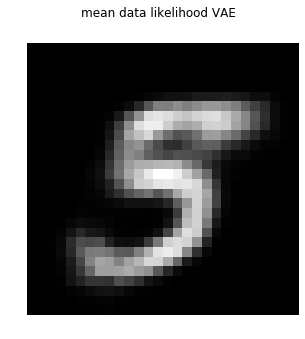

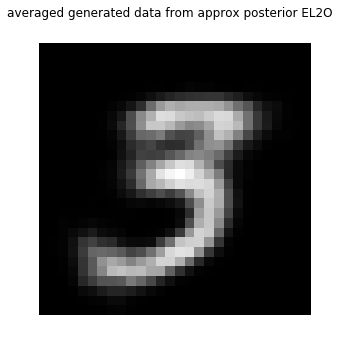

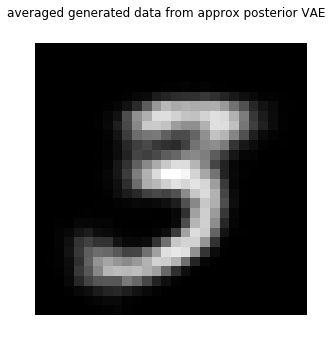

In [20]:
inim, xrecons2 = sess.run([x, x_samples_el2o], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size], sample_size:40})
xmean, xrecon  = sess.run([data_likelihood.mean(),x_samples], feed_dict={x_corr: x_train[0], x: x_train[0:batch_size], sample_size:40})


figure(figsize=(5,5))
suptitle('input images')
for i in range(1):
    subplot(1,1,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(1):
    subplot(1,1,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')




    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior EL2O')
for i in range(1):
    subplot(1,1,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior VAE')
for i in range(1):
    subplot(1,1,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

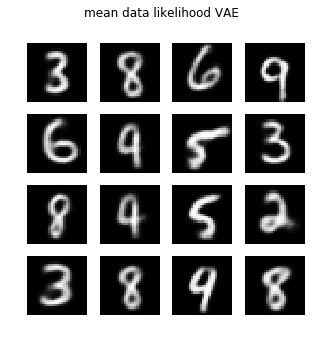

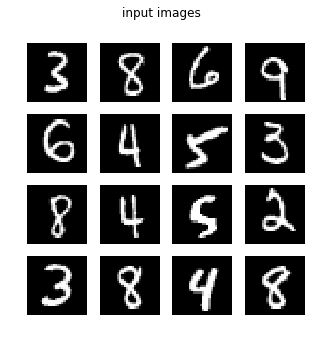

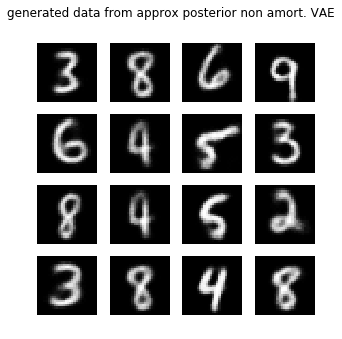

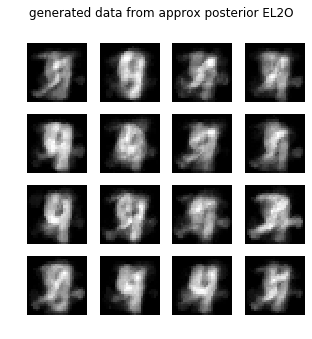

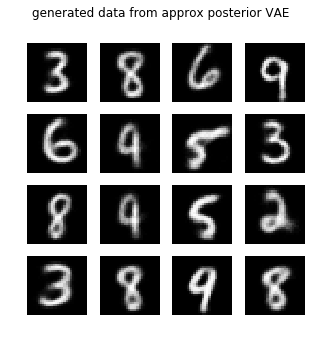

In [0]:
inim, xrecons2, xrecons3 = sess.run([x, x_samples_elbo, x_samples_el2o], feed_dict={x: masked_data[0:batch_size], sample_size: 20})
xmean, xrecon          = sess.run([data_likelihood.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})


figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


# figure(figsize=(5,5))
# suptitle('mean data likelihood non amortized VAE')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('generated data from approx posterior non amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('generated data from approx posterior EL2O')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons3[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
#has already been trained on one specific data set
data_from_mean_z = sess.run(likeli_zmean_elbo.mean(), feed_dict={x: masked_data[0:batch_size], mymask:mask, sample_size: 20})

(256, 784)


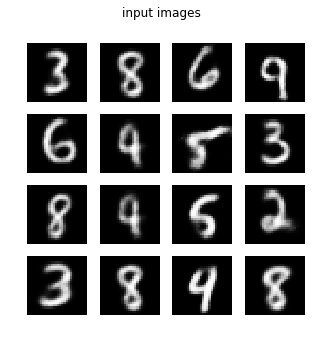

In [0]:
print(data_from_mean_z.shape)
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(data_from_mean_z[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


In [0]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

mask = np.asarray([mask]*batch_size)
print(mask.shape)
masked_data = x_valid[0:batch_size]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

(256, 784)


In [0]:
lrate=1e-2
for ii in range(1000):
  _, ll = sess.run([opt_op2b, mask_el2o], feed_dict={x: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_el2, sigma_el2], feed_dict={x: masked_data})
    print(mus[0:2],sigmas[0:2])
  print(ll)

In [0]:
lrate=1e-4
for ii in range(1000):
  _, ll = sess.run([opt_op2, mask_elbo], feed_dict={x: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_elbo, sigma_elbo], feed_dict={x: masked_data, mymask:mask})
    print(mus[0:10])
  print(ll)

[[-0.11698481  0.84114814  0.9807529  -1.3511785  -0.11780728 -0.5384949
  -1.0199325   1.0287744 ]
 [-0.6945425   0.9822733   0.6170864  -0.30664036 -0.4403797  -1.7033956
  -0.25006688 -0.69211996]
 [ 1.4396318   0.4914786  -1.089825    1.0073667   0.42448705  0.40432763
   2.055758    0.28558323]
 [-0.7639556   1.205469   -0.7214486   2.295088   -1.4656746  -0.25163025
   1.3052278   0.33136564]
 [ 0.6906573   2.2431293  -0.21138401  1.6033107   0.76804954 -0.03289237
   0.26941994 -0.786029  ]
 [ 0.03209121  0.80050933 -1.1324178   0.99301904 -0.747875   -0.6414098
   1.3786343   0.10258458]
 [-0.18849358 -1.7424717   1.1748654  -0.44990942 -0.26352742  0.20861554
  -1.2527642  -2.5093691 ]
 [ 0.15456307  1.658857    0.96508443 -0.23018835  0.32918265  0.3234713
   0.18989341  0.7772016 ]
 [-0.21939372  0.18554801  0.20367889 -0.50468016 -0.9383968  -1.476364
   0.17229922 -0.23419045]
 [ 0.5352906   0.8372905  -0.80733943  0.5202596  -1.1294528  -0.1513614
   0.5236861  -0.4230485

KeyboardInterrupt: ignored

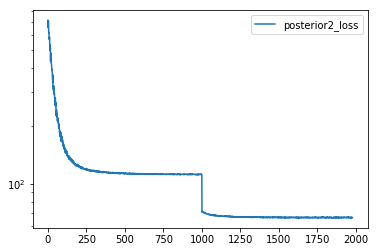

In [0]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [0]:
res3 = sess.run(z_samples_elbo, feed_dict={x: masked_data[0:batch_size]})
res = sess.run(z_samples, feed_dict={x: masked_data[0:batch_size]})

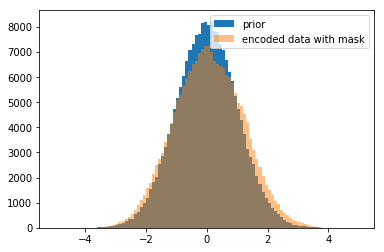

In [0]:
hist(randn(len(res3.flatten())),100,range=[-5,5],label='prior');
hist(res3.flatten(),100,range=[-5,5],alpha=0.5,label='encoded data with mask');
legend()

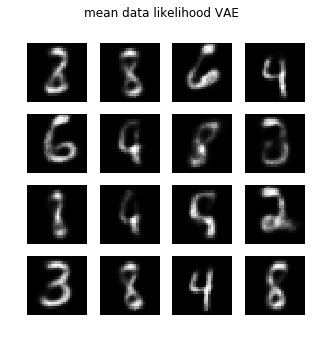

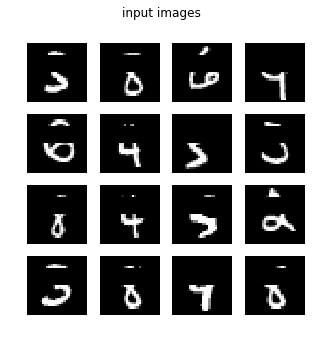

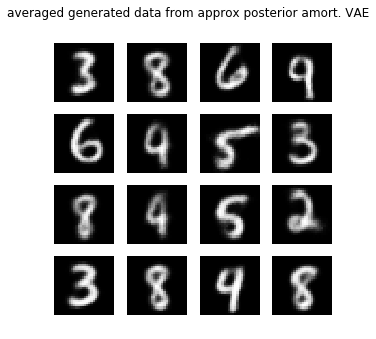

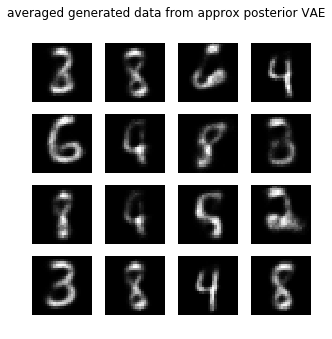

In [0]:
inim, xrecons2 = sess.run([x, x_samples_elbo], feed_dict={x: masked_data[0:batch_size], sample_size: 40})
xmean, xrecon          = sess.run([data_likelihood.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 40})

figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


# figure(figsize=(5,5))
# suptitle('mean data likelihood amortized VAE')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')